In [1]:
# All library l need for this assignment

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter


import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim

import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from PIL import Image

import time


# Part I

# 4.3.1 Dataset and Dataloader

In [13]:
data_path = './pa2_data/part1_data/train.csv'

df = pd.read_csv(data_path)
df = df.drop([2541, 3554, 4303, 4713, 5718, 9495]) # exclude grayscale pictures
df.index = range(len(df))
df.head()

,imdbId,Action,Adventure,Animation,Comedy,Drama,Horror,Romance
0,986264,0,0,0,0,1,0,0
1,1379182,0,0,0,0,1,0,0
2,361748,0,1,0,0,1,0,0
3,4175888,0,0,0,0,0,1,0
4,284445,1,1,0,0,0,1,0


In [14]:
# 10365 images
file = df['imdbId']

file = [str(i)+".jpg" for i in file]
file = [os.path.join("./pa2_data/part1_data/images", i) for i in file ]

label = np.array(df[['Action', 'Adventure', 'Animation', 'Comedy', 'Drama',
       'Horror', 'Romance']])

In [15]:
# Image transformation
transform = transforms.Compose(
    [transforms.Resize(32),
     transforms.ToTensor(),    # range [0, 255] -> [0.0,1.0]
     transforms.Normalize((0.5,), (0.5,))])   # channel=（channel-mean）/std  -> [-1, 1]


def default_loader(path):
    
    img_pil =  Image.open(path) 
    img_tensor = transform(img_pil)
    
    return img_tensor

In [16]:

class MovieDataset(Dataset):

    def __init__(self, file, label, loader=default_loader):
        
        self.images = file
        self.target = label
        self.loader = loader
        


    def __getitem__(self, idx):
        

        fn = self.images[idx]
        img = self.loader(fn)
        
        target = self.target[idx]
        
        return img, target


    def __len__(self):
        return len(self.target)

In [17]:
#for i in range(len(df)):
#    if default_loader(file[i]).size()[0] != 3:
#        print(i)

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [18]:
# split the data into train set and validation set

full_data = MovieDataset(file, label)

train_size = int(0.8 * len(full_data))
validation_size = len(full_data) - train_size

train, validation = random_split(full_data, [train_size, validation_size])

# 4.3.2 CNN Model Design

In [19]:
batch_size = 15

train_loader = DataLoader(train, batch_size=batch_size,
                          shuffle=True, num_workers=1)

valid_loader = DataLoader(validation, batch_size=batch_size,
                          shuffle=True, num_workers=1)


dataiter = iter(train_loader)
inputs, labels = dataiter.next()

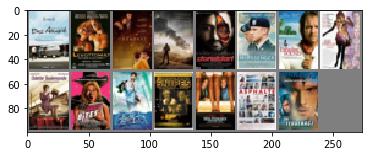

In [20]:
# show the posters 

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))



In [23]:
# torchsummary is not available in conda install, 
# you need to install using pip
#!pip install torchsummary



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, padding = 0, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 2, padding = 0, stride = 2)
        
        self.fc1 = nn.Linear(16*5*3, 128)
        self.fc2 = nn.Linear(128, 80)
        self.fc3 = nn.Linear(80, 7)
        
        self.bn1 = nn.BatchNorm1d(16*5*3)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(80)
        self.drops = nn.Dropout(0.3)

    def forward(self, x):
        
        #Three Conv2d layers
        x = self.pool(F.relu(self.conv1(x))) # 6, 21, 14
        x = self.pool(F.relu(self.conv2(x))) # 16, 5, 3

        x = x.view(-1, 16*5*3)
        # 3 BatchNorm1d and 2 dropouts
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        
        x = self.drops(x)
        
        x = self.bn2(x)
        x = F.relu(self.fc2(x))
        
        x = self.drops(x)
        
        x = self.bn3(x)
        x = self.fc3(x)
        return F.sigmoid(x)




## gpu or cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

summary(model, input_size=(3, 47, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 43, 28]             456
         MaxPool2d-2            [-1, 6, 21, 14]               0
            Conv2d-3            [-1, 16, 10, 7]             400
         MaxPool2d-4             [-1, 16, 5, 3]               0
       BatchNorm1d-5                  [-1, 240]             480
            Linear-6                  [-1, 128]          30,848
           Dropout-7                  [-1, 128]               0
       BatchNorm1d-8                  [-1, 128]             256
            Linear-9                   [-1, 80]          10,320
          Dropout-10                   [-1, 80]               0
      BatchNorm1d-11                   [-1, 80]             160
           Linear-12                    [-1, 7]             567
Total params: 43,487
Trainable params: 43,487
Non-trainable params: 0
---------------------------------

In [24]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/pa2_part1')

# add graph
writer.add_graph(model, inputs)
writer.close()

# run tensorboard --logdir='./runs'

//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1)

In [25]:
running_loss = 0.0
global_step = 0
eval_every = 20
num_epochs = 10
lr = 0.001
total_step = len(train_loader)*num_epochs

net = Net().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(num_epochs):  # loop over the dataset multiple times

    for i, (inputs, labels) in enumerate(train_loader):
        net.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
     
        '''Training of the model'''
        # Forward pass
        outputs = net(inputs)  
        loss = criterion(outputs, labels.float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1

        running_loss += loss.item()

        '''Evaluating the model every x steps'''
        if global_step % eval_every == 0:
            with torch.no_grad():
                net.eval()
                val_running_loss = 0.0
                for val_inputs, val_labels in valid_loader:
                    val_outputs = net(val_inputs)

                    val_loss = criterion(val_outputs, val_labels.float())
                    val_running_loss += val_loss.item()

                average_train_loss = running_loss / eval_every
                average_val_loss = val_running_loss / len(valid_loader)

                # ...log the running loss
                writer.add_scalar(
                    f'training loss {num_epochs}', average_train_loss, global_step)

                # ...log the running loss
                writer.add_scalar(
                    f'validation loss {num_epochs}', average_val_loss, global_step)

                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, total_step, average_train_loss, average_val_loss))

                running_loss = 0.0

print('Finished Training')

Epoch [1/10], Step [20/5530], Train Loss: 0.7154, Valid Loss: 0.7051
Epoch [1/10], Step [40/5530], Train Loss: 0.6891, Valid Loss: 0.6892
Epoch [1/10], Step [60/5530], Train Loss: 0.6740, Valid Loss: 0.6694
Epoch [1/10], Step [80/5530], Train Loss: 0.6619, Valid Loss: 0.6486
Epoch [1/10], Step [100/5530], Train Loss: 0.6461, Valid Loss: 0.6340
Epoch [1/10], Step [120/5530], Train Loss: 0.6293, Valid Loss: 0.6079
Epoch [1/10], Step [140/5530], Train Loss: 0.6029, Valid Loss: 0.5900
Epoch [1/10], Step [160/5530], Train Loss: 0.5888, Valid Loss: 0.5645
Epoch [1/10], Step [180/5530], Train Loss: 0.5558, Valid Loss: 0.5463
Epoch [1/10], Step [200/5530], Train Loss: 0.5438, Valid Loss: 0.5258
Epoch [1/10], Step [220/5530], Train Loss: 0.5184, Valid Loss: 0.5103
Epoch [1/10], Step [240/5530], Train Loss: 0.5128, Valid Loss: 0.4911
Epoch [1/10], Step [260/5530], Train Loss: 0.4968, Valid Loss: 0.4810
Epoch [1/10], Step [280/5530], Train Loss: 0.4977, Valid Loss: 0.4803
Epoch [1/10], Step [300/

Epoch [5/10], Step [2360/5530], Train Loss: 0.4614, Valid Loss: 0.4702
Epoch [5/10], Step [2380/5530], Train Loss: 0.4605, Valid Loss: 0.4584
Epoch [5/10], Step [2400/5530], Train Loss: 0.4712, Valid Loss: 0.4533
Epoch [5/10], Step [2420/5530], Train Loss: 0.4254, Valid Loss: 0.4542
Epoch [5/10], Step [2440/5530], Train Loss: 0.4355, Valid Loss: 0.4546
Epoch [5/10], Step [2460/5530], Train Loss: 0.4408, Valid Loss: 0.4546
Epoch [5/10], Step [2480/5530], Train Loss: 0.4539, Valid Loss: 0.4558
Epoch [5/10], Step [2500/5530], Train Loss: 0.4484, Valid Loss: 0.4550
Epoch [5/10], Step [2520/5530], Train Loss: 0.4496, Valid Loss: 0.4550
Epoch [5/10], Step [2540/5530], Train Loss: 0.4594, Valid Loss: 0.4562
Epoch [5/10], Step [2560/5530], Train Loss: 0.4510, Valid Loss: 0.4537
Epoch [5/10], Step [2580/5530], Train Loss: 0.4598, Valid Loss: 0.4545
Epoch [5/10], Step [2600/5530], Train Loss: 0.4643, Valid Loss: 0.4516
Epoch [5/10], Step [2620/5530], Train Loss: 0.4487, Valid Loss: 0.4539
Epoch 

Epoch [9/10], Step [4680/5530], Train Loss: 0.4498, Valid Loss: 0.4480
Epoch [9/10], Step [4700/5530], Train Loss: 0.4435, Valid Loss: 0.4480
Epoch [9/10], Step [4720/5530], Train Loss: 0.4342, Valid Loss: 0.4472
Epoch [9/10], Step [4740/5530], Train Loss: 0.4623, Valid Loss: 0.4473
Epoch [9/10], Step [4760/5530], Train Loss: 0.4576, Valid Loss: 0.4509
Epoch [9/10], Step [4780/5530], Train Loss: 0.4513, Valid Loss: 0.4495
Epoch [9/10], Step [4800/5530], Train Loss: 0.4397, Valid Loss: 0.4573
Epoch [9/10], Step [4820/5530], Train Loss: 0.4727, Valid Loss: 0.4487
Epoch [9/10], Step [4840/5530], Train Loss: 0.4575, Valid Loss: 0.4496
Epoch [9/10], Step [4860/5530], Train Loss: 0.4491, Valid Loss: 0.4482
Epoch [9/10], Step [4880/5530], Train Loss: 0.4535, Valid Loss: 0.4517
Epoch [9/10], Step [4900/5530], Train Loss: 0.4259, Valid Loss: 0.4509
Epoch [9/10], Step [4920/5530], Train Loss: 0.4310, Valid Loss: 0.4496
Epoch [9/10], Step [4940/5530], Train Loss: 0.4372, Valid Loss: 0.4494
Epoch 

In [71]:
# hyperparameter tunning
avg_training_loss = list()
avg_val_loss = list()
timer = list()


for learning_rate in [0.001, 0.0003, 0.0001]:

    running_loss = 0.0
    global_step = 0
    eval_every = 20
    num_epochs = 10
    lr = learning_rate
    total_step = len(train_loader)*num_epochs

    net = Net().to(device)
    m = nn.Sigmoid()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    start = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        for i, (inputs, labels) in enumerate(train_loader):
            net.train()
            inputs = inputs.to(device)
            labels = labels.to(device)

            '''Training of the model'''
            # Forward pass
            outputs = net(inputs)  
            loss = criterion(m(outputs), labels.float())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            global_step += 1

            running_loss += loss.item()

            '''Evaluating the model every x steps'''
            if global_step % eval_every == 0:
                with torch.no_grad():
                    net.eval()
                    val_running_loss = 0.0
                    for val_inputs, val_labels in valid_loader:
                        val_outputs = net(val_inputs)

                        val_loss = criterion(m(val_outputs), val_labels.float())
                        val_running_loss += val_loss.item()

                    average_train_loss = running_loss / eval_every
                    average_val_loss = val_running_loss / len(valid_loader)

                    # ...log the running loss
                    writer.add_scalar(
                        f'training loss {num_epochs}', average_train_loss, global_step)

                    # ...log the running loss
                    writer.add_scalar(
                        f'validation loss {num_epochs}', average_val_loss, global_step)

                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, total_step, average_train_loss, average_val_loss))

                    running_loss = 0.0

    print('Finished Training')
    avg_training_loss.append(average_train_loss)
    avg_val_loss.append(average_val_loss)
    timer.append(time.time()-start)



Epoch [1/10], Step [20/5530], Train Loss: 0.7076, Valid Loss: 0.6670
Epoch [1/10], Step [40/5530], Train Loss: 0.6815, Valid Loss: 0.6586
Epoch [1/10], Step [60/5530], Train Loss: 0.6585, Valid Loss: 0.6408
Epoch [1/10], Step [80/5530], Train Loss: 0.6521, Valid Loss: 0.6268
Epoch [1/10], Step [100/5530], Train Loss: 0.6317, Valid Loss: 0.6132
Epoch [1/10], Step [120/5530], Train Loss: 0.6174, Valid Loss: 0.5894
Epoch [1/10], Step [140/5530], Train Loss: 0.5952, Valid Loss: 0.5700
Epoch [1/10], Step [160/5530], Train Loss: 0.5826, Valid Loss: 0.5528
Epoch [1/10], Step [180/5530], Train Loss: 0.5590, Valid Loss: 0.5360
Epoch [1/10], Step [200/5530], Train Loss: 0.5436, Valid Loss: 0.5139
Epoch [1/10], Step [220/5530], Train Loss: 0.5218, Valid Loss: 0.5001
Epoch [1/10], Step [240/5530], Train Loss: 0.5121, Valid Loss: 0.4927
Epoch [1/10], Step [260/5530], Train Loss: 0.4944, Valid Loss: 0.4846
Epoch [1/10], Step [280/5530], Train Loss: 0.4834, Valid Loss: 0.4797
Epoch [1/10], Step [300/

Epoch [5/10], Step [2360/5530], Train Loss: 0.4765, Valid Loss: 0.4540
Epoch [5/10], Step [2380/5530], Train Loss: 0.4584, Valid Loss: 0.4572
Epoch [5/10], Step [2400/5530], Train Loss: 0.4885, Valid Loss: 0.4537
Epoch [5/10], Step [2420/5530], Train Loss: 0.4338, Valid Loss: 0.4587
Epoch [5/10], Step [2440/5530], Train Loss: 0.4541, Valid Loss: 0.4598
Epoch [5/10], Step [2460/5530], Train Loss: 0.4517, Valid Loss: 0.4569
Epoch [5/10], Step [2480/5530], Train Loss: 0.4405, Valid Loss: 0.4593
Epoch [5/10], Step [2500/5530], Train Loss: 0.4624, Valid Loss: 0.4583
Epoch [5/10], Step [2520/5530], Train Loss: 0.4550, Valid Loss: 0.4599
Epoch [5/10], Step [2540/5530], Train Loss: 0.4559, Valid Loss: 0.4570
Epoch [5/10], Step [2560/5530], Train Loss: 0.4580, Valid Loss: 0.4574
Epoch [5/10], Step [2580/5530], Train Loss: 0.4622, Valid Loss: 0.4609
Epoch [5/10], Step [2600/5530], Train Loss: 0.4434, Valid Loss: 0.4607
Epoch [5/10], Step [2620/5530], Train Loss: 0.4399, Valid Loss: 0.4553
Epoch 

Epoch [9/10], Step [4680/5530], Train Loss: 0.4482, Valid Loss: 0.4538
Epoch [9/10], Step [4700/5530], Train Loss: 0.4440, Valid Loss: 0.4564
Epoch [9/10], Step [4720/5530], Train Loss: 0.4241, Valid Loss: 0.4539
Epoch [9/10], Step [4740/5530], Train Loss: 0.4515, Valid Loss: 0.4552
Epoch [9/10], Step [4760/5530], Train Loss: 0.4646, Valid Loss: 0.4534
Epoch [9/10], Step [4780/5530], Train Loss: 0.4640, Valid Loss: 0.4538
Epoch [9/10], Step [4800/5530], Train Loss: 0.4378, Valid Loss: 0.4529
Epoch [9/10], Step [4820/5530], Train Loss: 0.4541, Valid Loss: 0.4636
Epoch [9/10], Step [4840/5530], Train Loss: 0.4473, Valid Loss: 0.4561
Epoch [9/10], Step [4860/5530], Train Loss: 0.4455, Valid Loss: 0.4540
Epoch [9/10], Step [4880/5530], Train Loss: 0.4390, Valid Loss: 0.4534
Epoch [9/10], Step [4900/5530], Train Loss: 0.4612, Valid Loss: 0.4516
Epoch [9/10], Step [4920/5530], Train Loss: 0.4470, Valid Loss: 0.4501
Epoch [9/10], Step [4940/5530], Train Loss: 0.4412, Valid Loss: 0.4511
Epoch 

Epoch [3/10], Step [1480/5530], Train Loss: 0.4791, Valid Loss: 0.4661
Epoch [3/10], Step [1500/5530], Train Loss: 0.4776, Valid Loss: 0.4646
Epoch [3/10], Step [1520/5530], Train Loss: 0.4655, Valid Loss: 0.4652
Epoch [3/10], Step [1540/5530], Train Loss: 0.4865, Valid Loss: 0.4673
Epoch [3/10], Step [1560/5530], Train Loss: 0.4635, Valid Loss: 0.4657
Epoch [3/10], Step [1580/5530], Train Loss: 0.4959, Valid Loss: 0.4671
Epoch [3/10], Step [1600/5530], Train Loss: 0.4692, Valid Loss: 0.4661
Epoch [3/10], Step [1620/5530], Train Loss: 0.4871, Valid Loss: 0.4683
Epoch [3/10], Step [1640/5530], Train Loss: 0.4952, Valid Loss: 0.4663
Epoch [4/10], Step [1660/5530], Train Loss: 0.4636, Valid Loss: 0.4643
Epoch [4/10], Step [1680/5530], Train Loss: 0.4665, Valid Loss: 0.4637
Epoch [4/10], Step [1700/5530], Train Loss: 0.4753, Valid Loss: 0.4647
Epoch [4/10], Step [1720/5530], Train Loss: 0.4614, Valid Loss: 0.4631
Epoch [4/10], Step [1740/5530], Train Loss: 0.4613, Valid Loss: 0.4622
Epoch 

Epoch [7/10], Step [3800/5530], Train Loss: 0.4783, Valid Loss: 0.4551
Epoch [7/10], Step [3820/5530], Train Loss: 0.4559, Valid Loss: 0.4553
Epoch [7/10], Step [3840/5530], Train Loss: 0.4579, Valid Loss: 0.4544
Epoch [7/10], Step [3860/5530], Train Loss: 0.4468, Valid Loss: 0.4564
Epoch [8/10], Step [3880/5530], Train Loss: 0.4863, Valid Loss: 0.4576
Epoch [8/10], Step [3900/5530], Train Loss: 0.4762, Valid Loss: 0.4552
Epoch [8/10], Step [3920/5530], Train Loss: 0.4419, Valid Loss: 0.4572
Epoch [8/10], Step [3940/5530], Train Loss: 0.4675, Valid Loss: 0.4551
Epoch [8/10], Step [3960/5530], Train Loss: 0.4881, Valid Loss: 0.4541
Epoch [8/10], Step [3980/5530], Train Loss: 0.4669, Valid Loss: 0.4553
Epoch [8/10], Step [4000/5530], Train Loss: 0.4522, Valid Loss: 0.4545
Epoch [8/10], Step [4020/5530], Train Loss: 0.4483, Valid Loss: 0.4546
Epoch [8/10], Step [4040/5530], Train Loss: 0.4585, Valid Loss: 0.4552
Epoch [8/10], Step [4060/5530], Train Loss: 0.4571, Valid Loss: 0.4553
Epoch 

Epoch [2/10], Step [600/5530], Train Loss: 0.6590, Valid Loss: 0.6367
Epoch [2/10], Step [620/5530], Train Loss: 0.6518, Valid Loss: 0.6386
Epoch [2/10], Step [640/5530], Train Loss: 0.6457, Valid Loss: 0.6271
Epoch [2/10], Step [660/5530], Train Loss: 0.6441, Valid Loss: 0.6357
Epoch [2/10], Step [680/5530], Train Loss: 0.6423, Valid Loss: 0.6309
Epoch [2/10], Step [700/5530], Train Loss: 0.6418, Valid Loss: 0.6253
Epoch [2/10], Step [720/5530], Train Loss: 0.6416, Valid Loss: 0.6302
Epoch [2/10], Step [740/5530], Train Loss: 0.6316, Valid Loss: 0.6290
Epoch [2/10], Step [760/5530], Train Loss: 0.6417, Valid Loss: 0.6298
Epoch [2/10], Step [780/5530], Train Loss: 0.6301, Valid Loss: 0.6231
Epoch [2/10], Step [800/5530], Train Loss: 0.6392, Valid Loss: 0.6205
Epoch [2/10], Step [820/5530], Train Loss: 0.6336, Valid Loss: 0.6188
Epoch [2/10], Step [840/5530], Train Loss: 0.6235, Valid Loss: 0.6208
Epoch [2/10], Step [860/5530], Train Loss: 0.6317, Valid Loss: 0.6209
Epoch [2/10], Step [

Epoch [6/10], Step [2920/5530], Train Loss: 0.4726, Valid Loss: 0.4724
Epoch [6/10], Step [2940/5530], Train Loss: 0.4772, Valid Loss: 0.4712
Epoch [6/10], Step [2960/5530], Train Loss: 0.4856, Valid Loss: 0.4700
Epoch [6/10], Step [2980/5530], Train Loss: 0.4829, Valid Loss: 0.4705
Epoch [6/10], Step [3000/5530], Train Loss: 0.4744, Valid Loss: 0.4716
Epoch [6/10], Step [3020/5530], Train Loss: 0.4839, Valid Loss: 0.4702
Epoch [6/10], Step [3040/5530], Train Loss: 0.4747, Valid Loss: 0.4716
Epoch [6/10], Step [3060/5530], Train Loss: 0.4729, Valid Loss: 0.4708
Epoch [6/10], Step [3080/5530], Train Loss: 0.4895, Valid Loss: 0.4708
Epoch [6/10], Step [3100/5530], Train Loss: 0.4829, Valid Loss: 0.4711
Epoch [6/10], Step [3120/5530], Train Loss: 0.4680, Valid Loss: 0.4709
Epoch [6/10], Step [3140/5530], Train Loss: 0.4853, Valid Loss: 0.4702
Epoch [6/10], Step [3160/5530], Train Loss: 0.4693, Valid Loss: 0.4686
Epoch [6/10], Step [3180/5530], Train Loss: 0.4780, Valid Loss: 0.4687
Epoch 

Epoch [10/10], Step [5240/5530], Train Loss: 0.4464, Valid Loss: 0.4589
Epoch [10/10], Step [5260/5530], Train Loss: 0.4703, Valid Loss: 0.4579
Epoch [10/10], Step [5280/5530], Train Loss: 0.4462, Valid Loss: 0.4613
Epoch [10/10], Step [5300/5530], Train Loss: 0.4716, Valid Loss: 0.4598
Epoch [10/10], Step [5320/5530], Train Loss: 0.4643, Valid Loss: 0.4590
Epoch [10/10], Step [5340/5530], Train Loss: 0.4779, Valid Loss: 0.4591
Epoch [10/10], Step [5360/5530], Train Loss: 0.4756, Valid Loss: 0.4606
Epoch [10/10], Step [5380/5530], Train Loss: 0.4794, Valid Loss: 0.4597
Epoch [10/10], Step [5400/5530], Train Loss: 0.4599, Valid Loss: 0.4592
Epoch [10/10], Step [5420/5530], Train Loss: 0.4586, Valid Loss: 0.4588
Epoch [10/10], Step [5440/5530], Train Loss: 0.4402, Valid Loss: 0.4597
Epoch [10/10], Step [5460/5530], Train Loss: 0.4774, Valid Loss: 0.4584
Epoch [10/10], Step [5480/5530], Train Loss: 0.4617, Valid Loss: 0.4589
Epoch [10/10], Step [5500/5530], Train Loss: 0.4864, Valid Loss:

In [72]:
avg_training_loss

[0.4479095220565796, 0.4511846587061882, 0.4689651608467102]

In [73]:
avg_val_loss

[0.4518907074448016, 0.45376535028004816, 0.4592733308136892]

In [75]:
timer

[897.3858160972595, 877.1827170848846, 858.0115337371826]

In [74]:
# load test csv
data_path = './pa2_data/part1_data/test.csv'
test = pd.read_csv(data_path)
test.index = range(len(test))


In [59]:
# find out grayscale pictures
for i in range(len(test)):
    if default_loader(file_test[i]).size()[0] != 3:
        print(i)

1191
1200


In [75]:
test = test.drop([1191, 1200])
file_test = test['imdbId']
file_test.index = range(len(file_test))

file_test = [str(i)+".jpg" for i in file_test]
file_test = [os.path.join("./pa2_data/part1_data/images/", i) for i in file_test ]
labels_test = np.array(test[['Action', 'Adventure', 'Animation', 'Comedy', 'Drama',
       'Horror', 'Romance']])

In [76]:
test_data = MovieDataset(file_test, labels_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                          shuffle=True, num_workers=1)

In [133]:
from sklearn.metrics import classification_report


def eval(model, test_loader, theta):
    y_test = []
    y_pred = []
    count = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            #model.eval()
            outputs = net(inputs)
            for i in range(len(outputs)):
                predict = list()
                raw = outputs[i].tolist()
        
                output = [(float(i)-min(raw))/(max(raw)-min(raw)) for i in raw]
                #print(output)
                #print(output)
                for j in range(7):
                    if (output[j] < theta):
                        predict.append(0)
                    else:
                        predict.append(1)
                        
                y_pred.append(predict)
                y_test.append(labels[i].tolist())

    print(classification_report(y_test, y_pred))


for theta in [0.3, 0.5, 0.8, 0.9]:
#for theta in [1]:
    print("the classification_report for theta: ", theta)
    eval(net, test_loader, theta)

the classification_report for theta:  0.3
              precision    recall  f1-score   support

           0       0.30      0.72      0.42       413
           1       0.24      0.26      0.25       254
           2       0.26      0.32      0.29       148
           3       0.45      0.92      0.60       772
           4       0.58      0.99      0.73      1151
           5       0.32      0.43      0.36       259
           6       0.28      0.72      0.41       417

   micro avg       0.42      0.78      0.54      3414
   macro avg       0.35      0.62      0.44      3414
weighted avg       0.42      0.78      0.54      3414
 samples avg       0.43      0.79      0.53      3414

the classification_report for theta:  0.4
              precision    recall  f1-score   support

           0       0.34      0.58      0.43       413
           1       0.27      0.19      0.22       254
           2       0.30      0.28      0.29       148
           3       0.50      0.81      0.62     

# 4.3.5 Prediction

In [148]:
# load prediction csv
data_path = './pa2_data/part1_data/submission.csv'
submission = pd.read_csv(data_path)

In [157]:
file_submission = submission['imdbId']

file_submission = [str(i)+".jpg" for i in file_submission]
file_submission = [os.path.join("./pa2_data/part1_data/images", i) for i in file_submission ]
labels_submission = list()
for i in range(len(file_submission)):
    labels_submission.append([0,0,0,0,0,0,0])

In [158]:
submit_data = MovieDataset(file_submission, labels)
submit_loader = DataLoader(submit_data, batch_size=batch_size,
                          shuffle=True, num_workers=1)

In [193]:
# From the classification report shown above, i think theta should be 0.3 to get the optimal f1 score
y_pred = []
count = 0


for inputs, labels in submit_loader:
    #model.eval()
    outputs = net(inputs)
    for i in range(len(outputs)):
        predict = list()
        raw = outputs[i].tolist()

        output = [(float(i)-min(raw))/(max(raw)-min(raw)) for i in raw]

        for j in range(7):
            if (output[j] < 0.3):
                predict.append(0)
            else:
                predict.append(1)

        y_pred.append(predict)


//anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [183]:
prediction = pd.DataFrame(y_pred)
#prediction = prediction.iloc[:, 1:7]
#prediction.colomns = []
#prediction.rename(columns = {'1':'Action'}, inplace = True)
prediction.columns = ['Action', 'Adventure', 'Animation', 'Comedy', 'Drama',
       'Horror', 'Romance']

In [191]:
prediction['imdbId'] = submission['imdbId']
prediction = prediction[['imdbId', 'Action', 'Adventure', 'Animation', 'Comedy', 'Drama',
       'Horror', 'Romance']]
prediction

,imdbId,Action,Adventure,Animation,Comedy,Drama,Horror,Romance
0,2960930,0,0,0,0,1,1,0
1,1295071,1,0,0,1,1,0,0
2,239441,1,0,0,1,1,0,1
3,305396,1,0,0,1,1,0,0
4,1413489,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...
586,3704050,1,0,0,1,1,1,0
587,477253,0,0,0,1,1,0,1
588,371606,1,0,0,0,1,1,0
589,392364,0,0,0,1,1,0,1


In [192]:
prediction.to_csv('prediction.csv')